In [2]:
from sympy import false, true
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
import matplotlib.pyplot as plt
import optuna
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os

In [ ]:
import numpy as np
import random

seed = 42

# PyTorch Seed
torch.manual_seed(seed)

# NumPy Seed
np.random.seed(seed)

# Python Zufallsgenerator Seed
random.seed(seed)

In [4]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)

In [5]:
# In Torch-Tensoren umwandeln
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Datasets und DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True, num_workers = 6)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 6)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 6)

In [6]:
num_threads = max(1, os.cpu_count() // 2)
torch.set_num_threads(num_threads)
print(f"PyTorch nutzt jetzt {torch.get_num_threads()} Threads")

PyTorch nutzt jetzt 6 Threads


In [7]:

# Device-Konfiguration für Apple M2 Max (MPS) oder CPU
USE_GPU = False
device = torch.device("mps" if USE_GPU and torch.backends.mps.is_available() else "cpu")
print(f"Modell läuft auf: {device}")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hp):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hp['lstm_units'], batch_first=True)
        self.dropout1 = nn.Dropout(hp['dropout_rate_lstm'])
        self.fc1 = nn.Linear(hp['lstm_units'], hp['dense_units'])
        self.dropout3 = nn.Dropout(hp['dropout_rate_dense'])
        self.fc2 = nn.Linear(hp['dense_units'], 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out



Modell läuft auf: cpu


In [8]:

# Objective-Funktion mit Hyperband-Pruning
def objective(trial):
    hp = {
        'lstm_units': trial.suggest_int('lstm_units', 32, 128, step=16),
        'dropout_rate_lstm': trial.suggest_float('dropout_rate_lstm', 0.1, 0.4, step=0.1),
        'dense_units': trial.suggest_int('dense_units', 16, 64, step=16),
        'dropout_rate_dense': trial.suggest_float('dropout_rate_dense', 0.0, 0.3, step=0.1),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4]),
        'weight_decay': trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3]),
    }

    model = LSTMModel(input_size=X_train.shape[2], hp=hp).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hp['learning_rate'], weight_decay=hp['weight_decay'])

    num_epochs = 15
    patience = 5
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Optuna-Pruning Check
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break

    return best_val_loss

# Erstelle Studie mit HyperbandPruner
pruner = optuna.pruners.HyperbandPruner(min_resource=3, max_resource=15, reduction_factor=3)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=30, n_jobs=6)

# Beste Hyperparameter ausgeben
print("Beste Hyperparameter:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-04-01 21:37:01,637] A new study created in memory with name: no-name-8c1c455d-0e1c-443a-a248-fde1ea9c15c6
[I 2025-04-01 21:39:42,988] Trial 4 finished with value: 0.0018413334285968073 and parameters: {'lstm_units': 32, 'dropout_rate_lstm': 0.1, 'dense_units': 64, 'dropout_rate_dense': 0.0, 'learning_rate': 0.0001, 'weight_decay': 0.001}. Best is trial 4 with value: 0.0018413334285968073.
[I 2025-04-01 21:40:02,324] Trial 5 pruned. 
[I 2025-04-01 21:40:48,036] Trial 0 finished with value: 0.0007363593139152433 and parameters: {'lstm_units': 80, 'dropout_rate_lstm': 0.30000000000000004, 'dense_units': 32, 'dropout_rate_dense': 0.3, 'learning_rate': 0.01, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0007363593139152433.
[I 2025-04-01 21:41:45,738] Trial 8 pruned. 
[I 2025-04-01 21:42:06,068] Trial 7 pruned. 
[I 2025-04-01 21:42:31,489] Trial 6 pruned. 
[I 2025-04-01 21:43:12,869] Trial 10 pruned. 
[I 2025-04-01 21:45:25,192] Trial 2 finished with value: 0.001616473573742

Beste Hyperparameter:
lstm_units: 96
dropout_rate_lstm: 0.2
dense_units: 48
dropout_rate_dense: 0.2
learning_rate: 0.001
weight_decay: 1e-05


In [9]:
# save best hyperparameters
best_hp = study.best_trial.params
with open("best_hp_all_models/best_hp_lstm.json", "w") as f:
    json.dump(best_hp, f)

In [10]:
# load best hyperparameters
with open("best_hp_all_models/best_hp_lstm.json", "r") as f:
    best_hp = json.load(f)

Epoch [1/50], Train Loss: 0.0066, Val Loss: 0.0028
Epoch [2/50], Train Loss: 0.0024, Val Loss: 0.0012
Epoch [3/50], Train Loss: 0.0017, Val Loss: 0.0008
Epoch [4/50], Train Loss: 0.0013, Val Loss: 0.0007
Epoch [5/50], Train Loss: 0.0011, Val Loss: 0.0009
Epoch [6/50], Train Loss: 0.0010, Val Loss: 0.0006
Epoch [7/50], Train Loss: 0.0009, Val Loss: 0.0008
Epoch [8/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [9/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [10/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [11/50], Train Loss: 0.0009, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [14/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [15/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [16/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [17/50], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [18/50], Train Loss: 0.0008, Val Loss: 0.0008
Epoch [19/50], Train Loss: 0.0008, Val Loss: 0.0006
Epoch [20/50], Train 

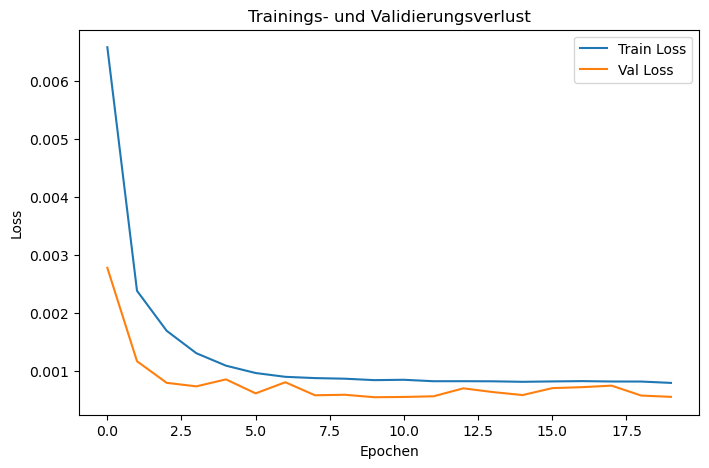

In [11]:
# Bestes Modell mit den gefundenen Hyperparametern trainieren
final_model = LSTMModel(input_size=X_train.shape[2], hp=best_hp)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_hp['learning_rate'], weight_decay=best_hp['weight_decay'])

num_epochs = 50
patience = 10  # Stop, wenn val_loss sich x Epochen lang nicht verbessert
best_val_loss = float('inf')
early_stopping_counter = 0
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation Loss berechnen
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = final_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset Counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping nach {epoch+1} Epochen.")
            break

# Save weights of the model 
torch.save(final_model.state_dict(), "saved_models/lstm_model_final.pth")


# **Trainingshistorie plotten**
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Trainings- und Validierungsverlust")
plt.show()

In [12]:
# load trained model  
lstm_final = LSTMModel(input_size=X_train.shape[2], hp=best_hp)
lstm_final.load_state_dict(torch.load("saved_models/lstm_model_final.pth"))
lstm_final.eval()

LSTMModel(
  (lstm1): LSTM(17, 96, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=96, out_features=48, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=48, out_features=1, bias=True)
)

Original Train MSE: 7.0612, Original Train RMSE: 2.6573
Original Validation MSE: 6.4661, Original Validation RMSE: 2.5429
Original Test MSE: 5.5285, Original Test RMSE: 2.3513
Scaled Test MSE: 0.0005, Scaled Test RMSE: 0.0219


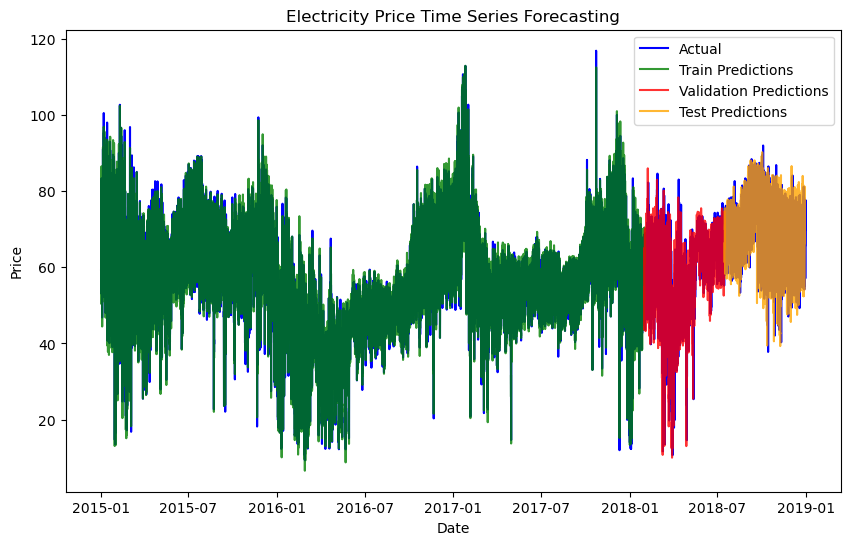

In [15]:
import import_ipynb
from feature_engineering import scaler_y
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions 
with torch.no_grad():
    train_predictions = lstm_final(X_train_tensor).numpy()
    validation_predictions = lstm_final(X_val_tensor).numpy()
    test_predictions = lstm_final(X_test_tensor).numpy()

# Inverse transform predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate loss on original scale
mse_train = mean_squared_error(y_train_actual, train_predictions)
rmse_train = np.sqrt(mse_train)

mse_val = mean_squared_error(y_val_actual, validation_predictions)
rmse_val = np.sqrt(mse_val)

mse_test = mean_squared_error(y_test_actual, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f"Original Train MSE: {mse_train:.4f}, Original Train RMSE: {rmse_train:.4f}")
print(f"Original Validation MSE: {mse_val:.4f}, Original Validation RMSE: {rmse_val:.4f}")
print(f"Original Test MSE: {mse_test:.4f}, Original Test RMSE: {rmse_test:.4f}")

# Optional: MSE and RMSE on scaled data (for reference)
train_scaled_preds = lstm_final(X_train_tensor)
val_scaled_preds = lstm_final(X_val_tensor)
test_scaled_preds = lstm_final(X_test_tensor)

mse_test_scaled = mean_squared_error(y_test_tensor.detach().numpy(), test_scaled_preds.detach().numpy())
rmse_test_scaled = np.sqrt(mse_test_scaled)
print(f"Scaled Test MSE: {mse_test_scaled:.4f}, Scaled Test RMSE: {rmse_test_scaled:.4f}")

# Plot of the forecast
plt.figure(figsize=(10, 6))

# Plot of actual values
seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Plot of training forecast
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green', alpha=0.8)

# Plot of validation forecast
validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions', color='red', alpha=0.8)

# Plot of test forecast
test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions', color='orange', alpha=0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
for name, param in lstm_final.named_parameters():
    print(f"{name}: {param.shape}")
    
total_params = sum(p.numel() for p in lstm_final.parameters())
print(f"Gesamtanzahl der Parameter: {total_params:,}")